In [1]:
import numpy as np
import scipy as sc
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
from EBL_MC_final_functions_local import *
from scipy.stats import norm
from scipy.stats import poisson
import yaml
import matplotlib.pyplot as plt
import h5py
import time
import sys
import os
import uproot
from scipy.stats import norm, chi2
from pathlib import Path

In [2]:
#Source info
Source_name = "1ES1011_Feb2014" #'PG1553_ST0203' "1ES1011_Feb2014", 'Mrk421_20130415c', #Check that you have all needed files before running
Source_z = 0.212
# Observation_time = 42480 #this is only needed for CTA
Emin = 0.059
Emax = 20.1 #15.

#Telescope
Telescope = "MAGIC" #only MAGIC is well implemented now
#EBL options
EBL_Model = "Dominguez" #there is only one a the moment
alpha_init = 0. #positon of the first initial guess.
alpha_min = 0. #lowest EBL scale factor
alpha_max = 2. #hightes EBL scale factor
alpha_step = 0.05 #EBL scale bin size
Chain_guess = True
#Fit function: PWL, LP, freeLP or MBPWL
fit_func_name = "LP"
IRF_u = True

#MBPWL info
Efirst = 0.379#0.389#0.143#0.11
DeltaE = 9.428#3.11#0.211#0.186
knots = 4#2

#Ohter options
Background_scale = 1.
Forward_folding = True #FIXME this makes no sense and should be remooved
Norm = 0.249

In [3]:
if Source_name == "Mrk421_20130415c":
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/Mrk421_20130415c/light+00/Output_flute.root"#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/{0}/data/nominal/flute/Output_flute.root".format(Source_name)#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/Mrk421_20130415c/data/nominal/flute/Output_flute.root"
else:
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/{0}/data/nominal/flute/Output_flute.root".format(Source_name)
alphas = alphas_creation(alpha_init, alpha_min, alpha_max, alpha_step)

fit_func = fit_func_select(fit_func_name, knots, Efirst, DeltaE)

if fit_func_name == "MBPWL":
    if Forward_folding:
        initial_guess_0 = np.zeros(knots+2)
        initial_guess_0[0] = 5e-6
        initial_guess_0[1] = 2.
    else:
        initial_guess_0 = np.zeros(knots+2)
        initial_guess_0[0] = 5e-6
        initial_guess_0[1] = 2.
elif fit_func_name == "PWL":
    if Forward_folding:
        initial_guess_0 = np.array([5e-6, 2.00])
    else:
        initial_guess_0 = np.array([5e-7, 2.]) #phi_0, gamma
elif fit_func_name == "LP":
    if Forward_folding:
        initial_guess_0 = np.array([5e-6, 2., 0.])
    else:
        initial_guess_0 = np.array([5e-7, 2., 0.]) #phi_0, alpha, beta
elif fit_func_name == "freeLP":
    if Forward_folding:
        initial_guess_0 = np.array([5e-6, 2., 0.])
    else:
        initial_guess_0 = np.array([5e-7, 2., 0.]) #phi_0, alpha, beta



if Telescope == "CTAN_alpha": #this part needs to be changed to include the real CTAN_alpha configuration
    Noffregions = 5
    def m2LogL(params):
        xdata = E_EBL
        mtau = -tau
        mu_gam0 = dNdE_to_mu((fit_func(xdata, params) * np.exp(mtau * alpha))[2:37], Effa_reb, Ebinsw[2:37], Observation_time, Ebins, Eres_reb2, E_EBL[2:37])
        mu_gam = mu_gam0[5:-4]
        mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
        min_num_gauss = 20
        conditions = [((Non >= min_num_gauss) & (Noff >= min_num_gauss)), (Non == 0.), (Noff == 0.), (Non != 0.) & (Noff != 0.)]
        choices = [Gauss_logL(Non, Noff, mu_gam, Noffregions), Poisson_logL_Non0(Non, Noff, mu_gam, Noffregions), Poisson_logL_Noff0(Non, Noff, mu_gam, Noffregions), Poisson_logL(Non, Noff, mu_gam, mu_bg, Noffregions)]
        res = np.select(conditions, choices, default = 999999999)
        return np.sum(res)
        
elif Telescope == "MAGIC":
    Noffregions = 3
    def m2LogL(params):
        xdata = Etrue
        mtau = -tau
        if IRF_u:
            mu_gam, mu_gam_u = dNdE_to_mu_MAGIC_IRF((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, migmaterr, Eest)
            mu_gam_final_u = mu_gam_u[minbin:maxbin]

        else:
            mu_gam = dNdE_to_mu_MAGIC((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, Eest)

        mu_gam_final = mu_gam[minbin:maxbin]
        Non_final = Non[minbin:maxbin] 
        Noff_final = Noff[minbin:maxbin]
        min_num_gauss = 20
    #####OLD not optimized way of doing this###########
        # if IRF_u:
        #     conditions = [((Non_final >= min_num_gauss) & (Noff_final >= min_num_gauss)), #change conditions and choices for irf
        #             (Non_final == 0.), 
        #             (Noff_final == 0.),
        #             (mu_gam_final < 1e-6),
        #             (mu_gam_final_u == 0),
        #             (Non_final != 0.) & (Noff_final != 0.)]
        #     choices = [Gauss_logL_IRF(Non_final, Noff_final, mu_gam_final, mu_gam_final_u, Noffregions),
        #             Poisson_logL_Non0_IRF(Non_final, Noff_final, mu_gam_final, mu_gam_final_u, Noffregions),
        #             Poisson_logL_Noff0_IRF(Non_final, Noff_final, mu_gam_final, mu_gam_final_u, Noffregions),
        #             Poisson_logL_small_mugam_IRF(Non_final, Noff_final, mu_gam_final, mu_gam_final_u, Noffregions),
        #             Poisson_logL_noIRF_IRF(Non_final, Noff_final, mu_gam_final, mu_gam_final_u, Noffregions),
        #             Poisson_logL_else_IRF(Non_final, Noff_final, mu_gam_final, mu_gam_final_u, Noffregions)]
        # else:
        #     conditions = [((Non_final >= min_num_gauss) & (Noff_final >= min_num_gauss)),
        #             (Non_final == 0.), 
        #             (Noff_final == 0.),
        #             (Non_final != 0.) & (Noff_final != 0.)]
        #     choices = [Gauss_logL(Non_final, Noff_final, mu_gam_final, Noffregions),
        #             Poisson_logL_Non0(Non_final, Noff_final, mu_gam_final, Noffregions),
        #             Poisson_logL_Noff0(Non_final, Noff_final, mu_gam_final, Noffregions),
        #             Poisson_logL_else(Non_final, Noff_final, mu_gam_final, Noffregions)]
        # res = np.select(conditions, choices, default = 999999999)

        #####NEW optimized way of doing this###########
        res = np.ones(len(Non_final)) * 999999999
        for i in range(len(Non_final)):
            if IRF_u:
                if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
                    res[i] = Gauss_logL_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif Non_final[i] == 0:
                    res[i] = Poisson_logL_Non0_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif Noff_final[i] == 0:
                    res[i] = Poisson_logL_Noff0_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif mu_gam_final[i] < 1e-6:
                    res[i] = Poisson_logL_small_mugam_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif mu_gam_final_u[i] == 0:
                    res[i] = Poisson_logL_noIRF_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif (Non_final[i] != 0) & (Noff_final[i] != 0):
                    res[i] = Poisson_logL_else_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            
            else:
                if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
                    res[i] = Gauss_logL(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
                elif Non_final[i] == 0:
                    res[i] = Poisson_logL_Non0(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
                elif Noff_final[i] == 0:
                    res[i] = Poisson_logL_Noff0(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
                elif (Non_final[i] != 0) & (Noff_final[i] != 0):
                    res[i] = Poisson_logL_else(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions) 

        return np.sum(res)

def fit(initial_guess):

    if fit_func_name == "MBPWL":
        if knots == 1:
            names = ("phi0", "gamma0", "Deltag0", "Eknot")
        else:
            names = ("phi0", "gamma0")
            for i in range(knots):
                names = names + ("Deltag{0}".format(i),)
    elif fit_func_name == "PWL":
        names = ("phi0", "gamma0")            
    else:
        names = ("phi0", "gamma0", "b")

    m2LogL.errordef = Minuit.LIKELIHOOD
    m = Minuit(m2LogL, initial_guess, name = names)   

    if fit_func_name == "MBPWL": #defines limits to faster and better find the minimum. Can be changed if the intrinsic spectrum function is changed. 
        MBPWL_limits = ([(1e-6, 1e-3), (-4., 5.)])
        errors = [1e-7, 0.01]
        for i in range(knots):
            MBPWL_limits.append(None)
            errors.append(0.01)
        m.limits = MBPWL_limits
    elif fit_func_name == "PWL":
        m.limits = ([(1e-7,1e-3), None]) #TODO canviar això al codi principal
        errors = [1e-7, 0.01]
    else:
        m.limits = ([(1e-7, 1e-3), (-2., None), (None, None)])
        errors = [1e-7, 0.01, 0.01]
    m.tol = 1e-6
    #m.strategy = 1
    m.errors = errors
     
    m.migrad()
    return m

# if EBL_Model == "Dominguez": #loads the EBL data of the Dominguez et al 2011 paper.
#     possible_z = np.array([0.01, 0.02526316, 0.04052632, 0.05578947, 0.07105263, 0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842, 0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421, 0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75])
#     closest_z = find_z(possible_z, Source_z)
#     file = np.loadtxt('/home/rgrau/Desktop/EBL-splines/tau_dominguez11.out')
#     pdfile = pd.DataFrame(file)
#     pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105', 15: 'tau z=0.22368421', 16: 'tau z=0.23894737', 17: 'tau z=0.25421053', 18: 'tau z=0.26947368', 19: 'tau z=0.28473684', 20: 'tau z=0.3' , 21: 'tau z=0.35', 22: 'tau z=0.4' , 23: 'tau z=0.45', 24: 'tau z=0.5', 25: 'tau z=0.55', 26: 'tau z=0.6', 27: 'tau z=0.65', 28: 'tau z=0.7' , 29: 'tau z=0.75'})
#     E_EBL = pdfile['E [TeV]'].to_numpy() #energy bins
#     tau_EBL = pdfile['tau z={0}'.format(closest_z)].to_numpy() #tau bins
# else:
#     raise Exception('The EBL model "{func}" has not been implemented.'.format(func = EBL_Model))

In [4]:
if Telescope == "MAGIC": #compute values needed for minimization if the selected telescope is MAGIC
    
    Bckg = uproot.open("{0}:hEstBckgE".format(data_path))#uproot.open(data_path + ":hEstBckgE")#load background values
    bckgmu_final = Bckg.values() #counts in 42480s (can be normalized for any time but as the migmatrix is for that time, only use that time).

    migrmatrix = uproot.open("/home/rgrau/Desktop/EBL-splines/fold_migmatrix_{0}.root:mig_matrix".format(Source_name))
    migmatval = migrmatrix.values() #m^2 * s #values
    if IRF_u:
        migmaterr = migrmatrix.errors()
    migmatxEtrue = migrmatrix.axis("x").edges()/1e3 #TeV #edge values of X axis of the migration matrix (True Energy)
    migmatyEest = migrmatrix.axis("y").edges()/1e3 #TeV #edge values of Y axis of the migration matrix (Estimated Energy)

    Eest = migrmatrix.axis("y").centers()/1e3 #TeV #center values of X axis of the migration matrix (True Energy)
    Etrue = migrmatrix.axis("x").centers()/1e3 #TeV #center values of Y axis of the migration matrix (Estimated Energy)
    E_final = Etrue
    Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
    minbin = Usedbins[0][0]
    maxbin = Usedbins[0][-1] + 1
    Eest_final = Eest[minbin:maxbin]
    
    tau = tau_interp(Etrue, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, Etrue) #interpolate the tau values to have the same bins as the migration matrix and the data.
    Ebinsw_final = migmatyEest[1:] - migmatyEest[:-1] #compute the bin width of the final energy bins
    Ebinsw_Etrue = migmatxEtrue[1:] - migmatxEtrue[:-1] #compute the bin width of Etrue energy bins

    excess = uproot.open("/home/rgrau/Desktop/EBL-splines/excess_{0}.root:_px".format(Source_name))
    excess_events = excess.values() #Energy bins = Eest

    mu_vec_final = excess_events

In [5]:
#change to scan alphas
def process2(alphas, mu_on, mu_off):
    chisqs = []
    chi_bf = 9999999
    global alpha, Non, Noff
    alpha = alpha_init
    Non, Noff = np.round(mu_on), np.round(Noffregions * mu_off)
    Non_u, Noff_u = np.sqrt(Non), np.sqrt(Noff)
    if Chain_guess:
        things = fit(initial_guess=initial_guess_0)
        if things.valid == False:
            raise Warning("The minimum is not valid")
        initial_guess_mat = ig_mat_create(fit_func_name, alphas, knots)
        initial_guess_mat[0] = things.values
        for i, alpha0 in enumerate(alphas):
            alpha = alpha0
            initial_guess = initial_guess_mat[i]
            if alpha == alpha_init:
                initial_guess = initial_guess_mat[0]
            things = fit(initial_guess = initial_guess)
            if things.valid == False:
                raise Warning("The minimum is not valid")
            if i < len(alphas):
                initial_guess_mat[i+1] = things.values
            chi2 = m2LogL(things.values)
            chisqs.append(chi2)
            if chi_bf > chi2:
                chi_bf = chi2
                bestfit = things.values
    else:
        for i, alpha0 in enumerate(alphas):
            alpha = alpha0
            things = fit(initial_guess = initial_guess_0)
            if things.valid == False:
                raise Warning("The minimum is not valid")
            chi2 = m2LogL(things.values)
            chisqs.append(chi2)
            if chi_bf > chi2:
                chi_bf = chi2
                bestfit = things.values
    return chisqs, bestfit

mu_on = mu_vec_final + bckgmu_final
mu_off = bckgmu_final 
chisqs, bestfit = process2(alphas, mu_on, mu_off)
print(bestfit)

<ValueView phi0=9.404376750448373e-06 gamma0=1.9251850369792272 b=-5.7480257179696917e-08>


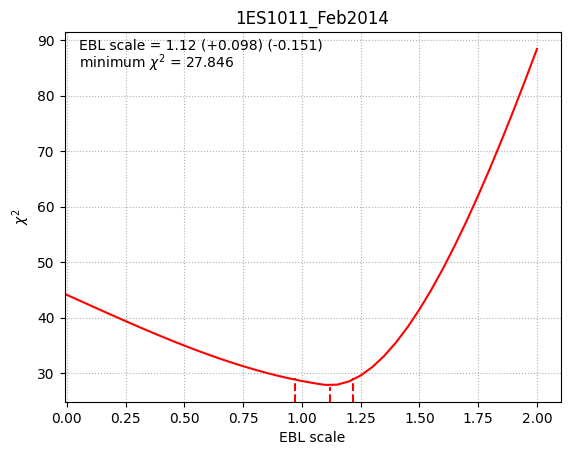

In [6]:
#plot of chi2 vs alpha
order = np.argsort(alphas)
alphas2 = np.take_along_axis(alphas, order, axis=-1)
chisqs2 = np.take_along_axis(np.array(chisqs), order, axis=-1)
interpx = np.arange(alpha_min, alpha_max, alpha_step/1000)
f1 = interpolate.interp1d(alphas2, chisqs2, kind='cubic')
chis_new = f1(interpx)
minimum = np.round(interpx[np.where(chis_new == np.min(chis_new))][0], decimals = 3)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound = np.round(interpx[np.max(sigma_inter_1s)], decimals = 3)
lower_bound = np.round(interpx[np.min(sigma_inter_1s)], decimals = 3)

plt.plot(alphas2, chisqs2, color = "red")
plt.axvline(minimum, ymax = 0.04, color = "red", linestyle = "--")
plt.axvline(upper_bound, ymax = 0.065, color = "red", linestyle = "--")
plt.axvline(lower_bound, ymax = 0.065, color = "red", linestyle = "--")
plt.xlabel("EBL scale")
plt.ylabel(r"$\chi^2$")
plt.grid(linestyle = ":")
plt.xlim(-0.01,None)
plt.title(Source_name)
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/1000, s="EBL scale = {0} (+{1}) (-{2})".format(minimum, np.round(upper_bound-minimum, decimals = 3), np.round(minimum-lower_bound, decimals = 3)))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/18, s = r"minimum $\chi^2$ = {0}".format(np.round(np.min(chis_new), decimals = 3)))
plt.show()

In [7]:
for i, alpha in enumerate(alphas2):
    if (alpha > 0.9) & (alpha < 1.2):
        print(alpha, chisqs2[i])

0.9000000000000001 29.509091580901828
0.9500000000000001 29.02249406913047
1.0 28.58730590794699
1.05 28.205504204672735
1.1 27.884759321419217
1.1500000000000001 27.934379985725705


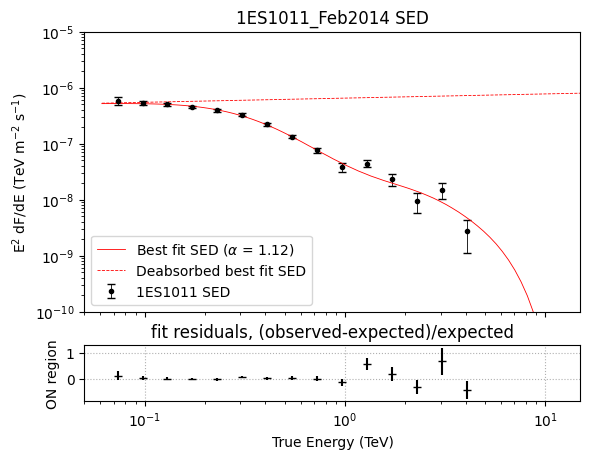

In [8]:
#FIXME change to the best fit alpha
alpha = minimum
mtau = -tau
Data = uproot.open(data_path + ":DiffEspectrum")
Data_values = Data.values()
dNdE_u = Data.errors("mean")[1]
dNdE = Data_values[1] # 1/ cm^2 / s / TeV
Eest_data = Data_values[0] * 1e-3 #TeV
mtau2 = -tau_interp(Eest_data, Source_z, EBL_Model, kind_of_interp = "log")#-log_interp1d(E_EBL, tau_EBL, Eest_data)
SED_orig = Eest_data * Eest_data * dNdE * 1e4 #put it in 1/m^2 instead of 1/cm^2
SED_orig_u = Eest_data *  Eest_data * dNdE_u *1e4
SED_fit = fit_func(Etrue, bestfit) * np.exp(mtau * alpha) * Etrue * Etrue
SED_fit_deabs = fit_func(Etrue, bestfit) * Etrue * Etrue
SED_fit2 = fit_func(Eest_data, bestfit) * np.exp(mtau2 * alpha) * Eest_data * Eest_data
binw = np.zeros(len(Eest)-1)

Etrue_bins = np.where((Emin <= Etrue) & (Etrue <= Emax))
minbin_tr = Etrue_bins[0][0]
maxbin_tr = Etrue_bins[0][-1] + 1

f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "1ES1011 SED", color = "black", linewidth = 0.6)
# ax1.errorbar(Eest_final, SED_orig, yerr=SED_orig_u, fmt = ".", label = "Assimov dataset SED")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = r"Best fit SED ($\alpha$ = {0})".format(alpha), color = 'red', linewidth = 0.6)
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit_deabs[minbin_tr:maxbin_tr], linestyle = "--", label = "Deabsorbed best fit SED", color = 'red', linewidth = 0.6)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel("True Energy (TeV)")
ax1.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
ax1.set_title("{0} SED".format(Source_name))
ax1.legend()
ax1.set_xlim(5e-2, 1.5e1)
ax1.set_ylim(1e-10, 1e-5)
ax2.errorbar(Eest_data, (SED_orig - SED_fit2) / SED_fit2 , yerr= SED_orig_u / SED_fit2, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("ON region")
ax2.grid(linestyle = ":")
# ax2.set_yscale('log')
plt.show()

## Compute residuals correctly

In [9]:
# Emin = 0.06
# Emax = 10
Emin = 0.059
Emax = 20.1 #15.

Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
minbin = Usedbins[0][0]
maxbin = Usedbins[0][-1] + 1
def Poisson_logL_Non0_IRF_mus(Non, Noff, mu_gam, delta_mu_gam, Noffregions): #canviat per IRF
    mu_bg = Noff / (1. + Noffregions)
    mu_gam2 = -np.square(delta_mu_gam) + mu_gam
    if mu_gam2 < 0.:#FIXME?
        mu_gam2 = 0
    return mu_gam2, mu_bg

def Poisson_logL_Noff0_IRF_mus(Non, Noff, mu_gam, delta_mu_gam, Noffregions):
    fAlpha = 1/Noffregions
    mu_bg = fAlpha * Non / (1 + fAlpha) - mu_gam -np.square(delta_mu_gam)/fAlpha
    if mu_bg < 0.:
        mu_bg = 0
        a = 1.
        b = -mu_gam + np.square(delta_mu_gam)
        c = -Non + np.square(delta_mu_gam)
        mu_gam2 = (-b + np.sqrt(np.square(b) - 4 * a * c)) / (2. * a)
    else:
        mu_gam2 = mu_gam + np.square(delta_mu_gam) / fAlpha
    return mu_gam2, mu_bg

def Poisson_logL_else_IRF_mus(Non, Noff, mu_gam, delta_mu_gam, Noffregions):
    mu_gam2, mu_bg = best_mubg_mugam_IRF(Non, Noff, mu_gam, delta_mu_gam, Noffregions)
    if np.isnan(mu_gam2):
        return 99999999999999
    elif mu_gam2 < 0.:
        mu_gam2 = 0
        mu_bg = (Non + Noff)/ (1 + Noffregions)
    return mu_gam2, mu_bg

def Poisson_logL_small_mugam_IRF_mus(Non, Noff, mu_gam, delta_mu_gam, Noffregions):
    fAlpha = 1/Noffregions
    mu_bg = fAlpha * (Noff + Non) / (1+fAlpha)
    return mu_gam, mu_bg


alpha = minimum
xdata = Etrue
mtau = -tau
Non, Noff = np.round(mu_on), np.round(Noffregions * mu_off) #FIXME: round?
mu_gam, mu_gam_u = dNdE_to_mu_MAGIC_IRF((fit_func(xdata, bestfit) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, migmaterr, Eest)
mu_gam_final_u = mu_gam_u[minbin:maxbin]
mu_gam_final = mu_gam[minbin:maxbin]
Non_final = Non[minbin:maxbin] 
Non_final_u = np.sqrt(Non_final)
Noff_final = Noff[minbin:maxbin]
min_num_gauss = 20
mu_gam_f = np.zeros(len(Non_final))
mu_bg_f = np.zeros(len(Noff_final))


for i in range(len(Non_final)):
    if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
        mu_gam_f[i], mu_bg_f[i] = mu_gam_final[i], Noff_final[i] / Noffregions
    elif Non_final[i] == 0:
        mu_gam_f[i], mu_bg_f[i] = Poisson_logL_Non0_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
    elif Noff_final[i] == 0:
        mu_gam_f[i], mu_bg_f[i] = Poisson_logL_Noff0_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
    elif mu_gam_final[i] < 1e-6:
        mu_gam_f[i], mu_bg_f[i] = Poisson_logL_small_mugam_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
    elif mu_gam_final_u[i] == 0:
        mu_gam_f[i], mu_bg_f[i] = mu_gam_final[i], mu_BG(mu_gam_final[i], Non_final[i], Noff_final[i], Noffregions)
    elif (Non_final[i] != 0) & (Noff_final[i] != 0):
        mu_gam_f[i], mu_bg_f[i] = Poisson_logL_else_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)

mu_on_f_sim = mu_gam_f + mu_bg_f

############compute uncertainties############

def m2LogL_unc(params):
    xdata = Etrue
    mtau = -tau
    if IRF_u:
        mu_gam, mu_gam_u = dNdE_to_mu_MAGIC_IRF((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, migmaterr, Eest)
        mu_gam_final_u = mu_gam_u[minbin:maxbin]

    else:
        mu_gam = dNdE_to_mu_MAGIC((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, Eest)

    mu_gam_final = mu_gam[minbin:maxbin]
    Non_final = Non[minbin:maxbin] 
    Noff_final = Noff[minbin:maxbin]
    min_num_gauss = 20

    res = np.ones(len(Non_final)) * 999999999
    for i in range(len(Non_final)):
        if IRF_u:
            if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
                res[i] = Gauss_logL_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif Non_final[i] == 0:
                res[i] = Poisson_logL_Non0_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif Noff_final[i] == 0:
                res[i] = Poisson_logL_Noff0_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif mu_gam_final[i] < 1e-6:
                res[i] = Poisson_logL_small_mugam_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif mu_gam_final_u[i] == 0:
                res[i] = Poisson_logL_noIRF_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif (Non_final[i] != 0) & (Noff_final[i] != 0):
                res[i] = Poisson_logL_else_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
        
        else:
            if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
                res[i] = Gauss_logL(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
            elif Non_final[i] == 0:
                res[i] = Poisson_logL_Non0(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
            elif Noff_final[i] == 0:
                res[i] = Poisson_logL_Noff0(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
            elif (Non_final[i] != 0) & (Noff_final[i] != 0):
                res[i] = Poisson_logL_else(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions) 

    return res
chi2vals = m2LogL_unc(bestfit)
uncertainty = np.sqrt(chi2vals)

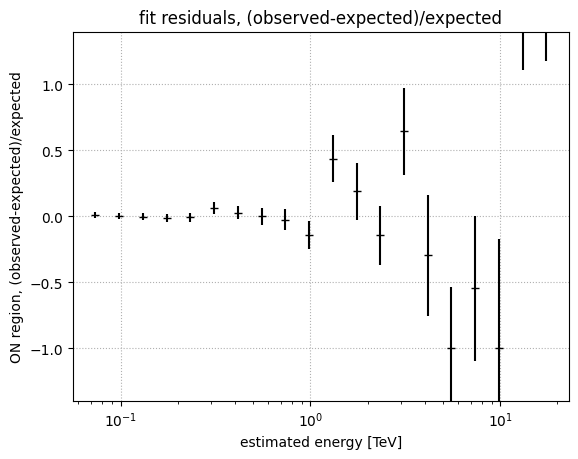

In [10]:
#np.round(mu_on) = Non 
error = np.abs(((Non_final) / mu_on_f_sim)-1) / uncertainty
plt.errorbar(Eest[minbin:maxbin], (Non_final - mu_on_f_sim) / mu_on_f_sim , yerr= error, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
plt.title("fit residuals, (observed-expected)/expected")
plt.ylabel("ON region, (observed-expected)/expected")
plt.xlabel("estimated energy [TeV]")
plt.grid(linestyle = ":")
plt.xscale('log')
plt.ylim(-1.4, 1.4)
# ax2.set_yscale('log')
plt.show()

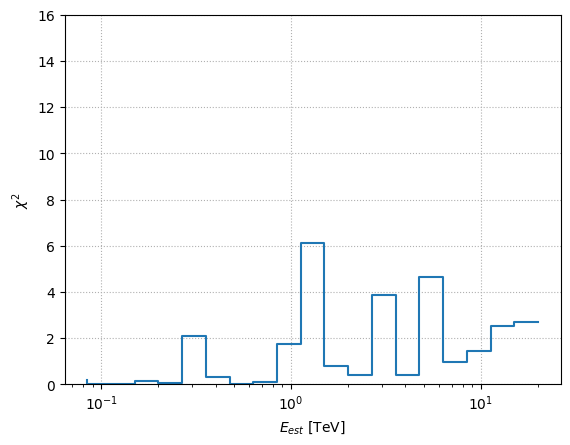

In [11]:
####################plot ON##########
# plt.errorbar(Eest[minbin:maxbin], Non_final, yerr = np.sqrt(Non_final), label = "observed", fmt = "_",  color = "black")
# plt.errorbar(Eest[minbin:maxbin], mu_on_f_sim, label = "expected", yerr = np.sqrt(mu_on_f_sim), fmt = "_",  color = "red")
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()

##################plot Chi2################
newEest = migmatyEest[1:]
plt.step(newEest[minbin:maxbin], chi2vals)
plt.grid(linestyle = ":")
plt.ylabel(r"$\chi^2$")
plt.xlabel(r"$E_{est}$ [TeV]")
plt.ylim(0, 16)
plt.xscale('log')
plt.show()

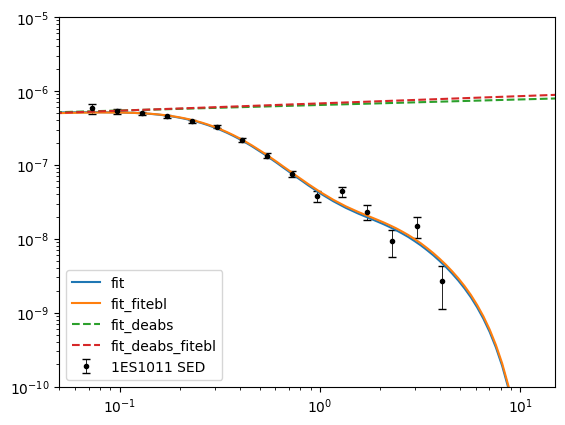

In [12]:
SED_fit = fit_func(Etrue, bestfit) * np.exp(mtau * alpha) * Etrue * Etrue
SED_fit_deabs = fit_func(Etrue, bestfit) * Etrue * Etrue
bestfit_fitebl = np.array([9.56347285014192e-06, 1.90185, 1.77207e-08])
SED_fit_fitebl = fit_func(Etrue, bestfit_fitebl) * np.exp(mtau * 1.123) * Etrue * Etrue
SED_fit_deabs_fitebl = fit_func(Etrue, bestfit_fitebl) * Etrue * Etrue

plt.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "1ES1011 SED", color = "black", linewidth = 0.6)
plt.plot(Etrue, SED_fit, label = "fit")
plt.plot(Etrue, SED_fit_fitebl, label = "fit_fitebl")
plt.plot(Etrue, SED_fit_deabs, label = "fit_deabs", linestyle = "--")
plt.plot(Etrue, SED_fit_deabs_fitebl, label = "fit_deabs_fitebl", linestyle = "--")
plt.legend()
plt.xlim(5e-2, 1.5e1)
plt.ylim(1e-10, 1e-5)
plt.xscale('log')
plt.yscale('log')
plt.show()

#[0]*pow(x/%.2f,[1]-[2]*[2]*log10(x/%.2f))
#[0]+([1]-[2]*[2]*log10(x/%.2f))*log(x/%.2f)
#phi0 * np.power((xdata/0.249), (-alpha - beta * beta * np.log10(xdata/0.249)))

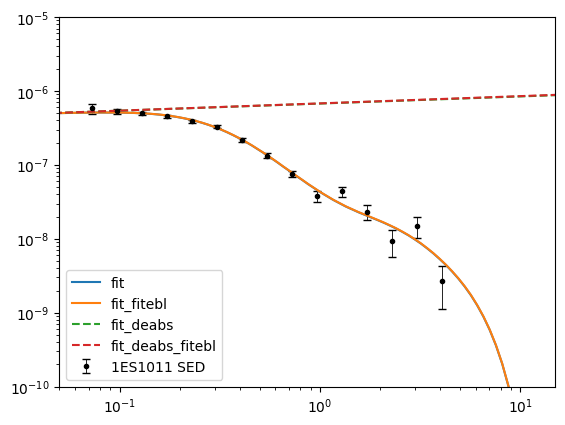

<ValueView phi0=9.53502778176321e-06 gamma0=1.9036824180437784 b=-4.836931045824915e-08>
[9.56347285014192e-06, 1.90185, 1.77207e-08]
[27.840592044210744]
27.865553856716076


In [13]:
chisq123, bestfit123 = process2([1.123], mu_on, mu_off)
SED_fit_123 = fit_func(Etrue, bestfit123) * np.exp(mtau * 1.123) * Etrue * Etrue
SED_fit_123_deabs = fit_func(Etrue, bestfit123) * Etrue * Etrue
bestfit_fitebl = np.array([9.56347285014192e-06, 1.90185, 1.77207e-08])
SED_fit_fitebl = fit_func(Etrue, bestfit_fitebl) * np.exp(mtau * 1.123) * Etrue * Etrue
SED_fit_deabs_fitebl = fit_func(Etrue, bestfit_fitebl) * Etrue * Etrue

plt.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "1ES1011 SED", color = "black", linewidth = 0.6)
plt.plot(Etrue, SED_fit_123, label = "fit")
plt.plot(Etrue, SED_fit_fitebl, label = "fit_fitebl")
plt.plot(Etrue, SED_fit_123_deabs, label = "fit_deabs", linestyle = "--")
plt.plot(Etrue, SED_fit_deabs_fitebl, label = "fit_deabs_fitebl", linestyle = "--")
plt.legend()
plt.xlim(5e-2, 1.5e1)
plt.ylim(1e-10, 1e-5)
plt.xscale('log')
plt.yscale('log')
plt.show()
print(bestfit123)
print([9.56347285014192e-06, 1.90185, 1.77207e-08])
print(chisq123)
print(m2LogL([9.56347285014192e-06, 1.90185, 1.77207e-08]))

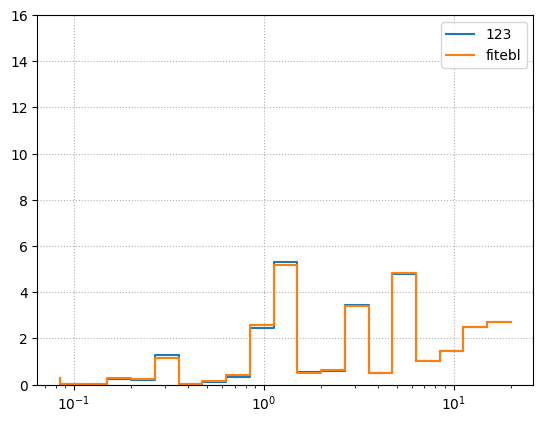

[ 0.07379243  0.09840378  0.13122355  0.17498942  0.23335214  0.31118008
  0.41496531  0.55336514  0.73792427  0.98403783  1.31223553  1.74989421
  2.33352143  3.11180084  4.14965312  5.53365137  7.37924269  9.84037829
 13.12235535 17.49894209] [0.27047101 0.0192859  0.00991082 0.27958763 0.25635244 1.13689973
 0.02123441 0.15119825 0.40606786 2.57611176 5.1737456  0.499367
 0.63783287 3.39173112 0.52251411 4.8175433  1.01673708 1.47456489
 2.49056588 2.71383219]


In [14]:
chi2vals_fitebl = m2LogL_unc([9.56347285014192e-06, 1.90185, 1.77207e-08])
chi2vals_123 = m2LogL_unc(bestfit123)
plt.step(newEest[minbin:maxbin], chi2vals_123, label = "123")
plt.step(newEest[minbin:maxbin], chi2vals_fitebl, label = "fitebl")
plt.grid(linestyle = ":")
plt.ylim(0, 16)
plt.xscale('log')
plt.legend()
plt.show()
print(Eest[minbin:maxbin],chi2vals_fitebl)

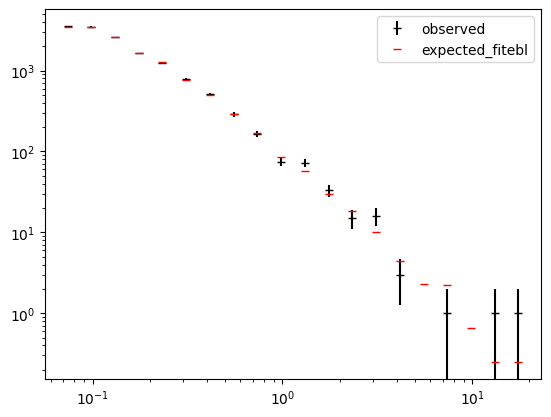

[3.48649353e+03 3.46153396e+03 2.57365462e+03 1.65269328e+03
 1.26610989e+03 7.64156001e+02 5.06261202e+02 2.92348640e+02
 1.71548321e+02 8.61696565e+01 5.68905385e+01 2.98334060e+01
 1.81850174e+01 1.00537111e+01 4.43191656e+00 2.29572543e+00
 2.22921279e+00 6.61918298e-01 2.50000000e-01 2.50000000e-01]


In [15]:
def mu_on_comp(alpha, bestfit):
    xdata = Etrue
    mtau = -tau
    Non, Noff = np.round(mu_on), np.round(Noffregions * mu_off) #FIXME: round?
    mu_gam, mu_gam_u = dNdE_to_mu_MAGIC_IRF((fit_func(xdata, bestfit) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, migmaterr, Eest)
    mu_gam_final_u = mu_gam_u[minbin:maxbin]
    mu_gam_final = mu_gam[minbin:maxbin]
    Non_final = Non[minbin:maxbin] 
    Non_final_u = np.sqrt(Non_final)
    Noff_final = Noff[minbin:maxbin]
    min_num_gauss = 20
    mu_gam_f = np.zeros(len(Non_final))
    mu_bg_f = np.zeros(len(Noff_final))

    for i in range(len(Non_final)):
        if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
            mu_gam_f[i], mu_bg_f[i] = mu_gam_final[i], (Non_final[i] - mu_gam_final[i] + Noff_final[i]) / (1 + Noffregions) #(observed-expectedgammas + numoffevents) / (1.+1./fAlpha)
        elif Non_final[i] == 0:
            mu_gam_f[i], mu_bg_f[i] = Poisson_logL_Non0_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
        elif Noff_final[i] == 0:
            mu_gam_f[i], mu_bg_f[i] = Poisson_logL_Noff0_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
        elif mu_gam_final[i] < 1e-6:
            mu_gam_f[i], mu_bg_f[i] = Poisson_logL_small_mugam_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
        elif mu_gam_final_u[i] == 0:
            mu_gam_f[i], mu_bg_f[i] = mu_gam_final[i], mu_BG(mu_gam_final[i], Non_final[i], Noff_final[i], Noffregions)
        elif (Non_final[i] != 0) & (Noff_final[i] != 0):
            mu_gam_f[i], mu_bg_f[i] = Poisson_logL_else_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)

    mu_on_f_sim = mu_gam_f + mu_bg_f
    return mu_on_f_sim

ON_f123 = mu_on_comp(1.123, bestfit123)
ON_fitebl = mu_on_comp(1.123, bestfit_fitebl)

plt.errorbar(Eest[minbin:maxbin], Non_final, yerr = np.sqrt(Non_final), label = "observed", fmt = "_",  color = "black")
# plt.errorbar(Eest[minbin:maxbin], ON_f123, label = "expected_123", yerr = np.sqrt(ON_f123), fmt = "_",  color = "orange")
plt.errorbar(Eest[minbin:maxbin], ON_fitebl, label = "expected_fitebl", fmt = "_",  color = "red")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
print(ON_fitebl)

## Now plot it with the SED (more SED points missing)

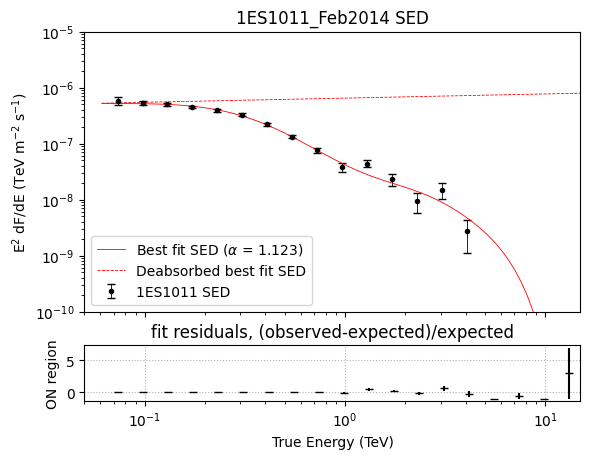

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "1ES1011 SED", color = "black", linewidth = 0.6)
# ax1.errorbar(Eest_final, SED_orig, yerr=SED_orig_u, fmt = ".", label = "Assimov dataset SED")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = r"Best fit SED ($\alpha$ = {0})".format(alpha), color = 'red', linewidth = 0.6)
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit_deabs[minbin_tr:maxbin_tr], linestyle = "--", label = "Deabsorbed best fit SED", color = 'red', linewidth = 0.6)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel("True Energy (TeV)")
ax1.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
ax1.set_title("{0} SED".format(Source_name))
ax1.legend()
ax1.set_xlim(5e-2, 1.5e1)
ax1.set_ylim(1e-10, 1e-5)
ax2.errorbar(Eest[minbin:maxbin], (Non_final - mu_on_f_sim) / mu_on_f_sim , yerr= Non_final_u / mu_on_f_sim, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("ON region")
ax2.grid(linestyle = ":")
# ax2.set_yscale('log')
plt.show()

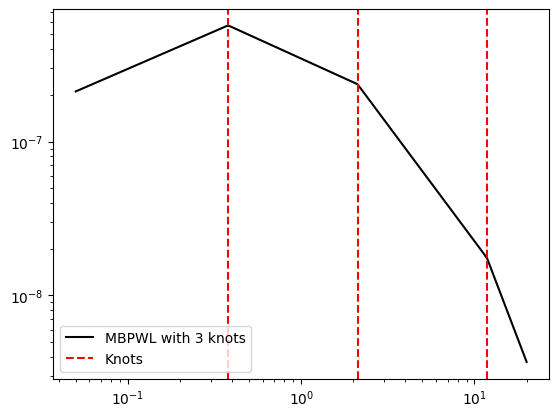

In [17]:
MBPWL = fit_func_select("MBPWL", knots = 3, Efirst = Efirst, DeltaE = DeltaE+2)
Energy_plot = np.geomspace(5e-2, 2.e1, 150)
Ebr = np.geomspace(Efirst, Efirst+ DeltaE+2, 3)
SED_fitplot = MBPWL(Energy_plot, np.array([7.471428040974111e-06, 1.5119396033218624, 1., 1., 1.2])) * np.square(Energy_plot)
plt.plot(Energy_plot, SED_fitplot, color = 'black', label = "MBPWL with 3 knots")
plt.axvline(Efirst, label = "Knots", color = "red", linestyle = "--")
plt.axvline(Ebr[1], color = "red", linestyle = "--")
plt.axvline(Ebr[2], color = "red", linestyle = "--")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Example of EBL absorption:

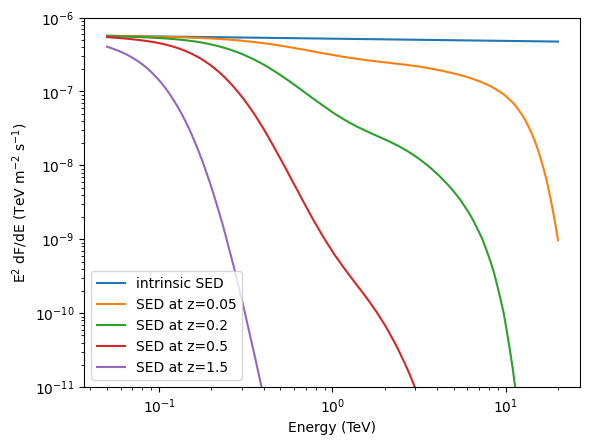

In [18]:
redshifts = [0., 0.05, 0.2, 0.5, 1.5]
PWL = fit_func_select("PWL")
Energy_plot = np.geomspace(5e-2, 2.e1, 150)
for i in redshifts:
    if i == 0.:
        SED_plot = PWL(Energy_plot, [8.7e-6, 2.03]) * np.square(Energy_plot)
        plt.plot(Energy_plot, SED_plot, label = 'intrinsic SED'.format(i))
    else:
        tau2 = tau_interp(Energy_plot, i, "Dominguez", kind_of_interp = "log")
        SED_plot = PWL(Energy_plot, [8.7e-6, 2.03]) * np.exp(-tau2) * np.square(Energy_plot)
        plt.plot(Energy_plot, SED_plot, label = 'SED at z={0}'.format(i))

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-6)
plt.xlabel('Energy (TeV)')
plt.ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
plt.show()